### Imports:
<p>Bibliotecas para analise exploratoria dos dados de temperatura.</p>

In [1]:
import pandas as pd # manipular dataframe
import numpy as np # manipular arrays
import matplotlib.pyplot as plt # criar graficos
import seaborn as sns # criar graficos
from statistics import mode # estatistica: moda
import warnings; warnings.filterwarnings('ignore') # remover avisos

### Importar base de dados

<p>
df recebe dados de temperatura por cidade (GlobalLandTemperaturesByCity.csv);<br>
countinents recebe continentes de cada pais (Continents.csv).
<p>

In [2]:
df = pd.read_csv('Datasets/GlobalLandTemperaturesByCity.csv')
countinents = pd.read_csv('Datasets/Continents.csv', encoding='latin-1')
df.head(10)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
5,1744-04-01,5.788,3.624,Århus,Denmark,57.05N,10.33E
6,1744-05-01,10.644,1.283,Århus,Denmark,57.05N,10.33E
7,1744-06-01,14.051,1.347,Århus,Denmark,57.05N,10.33E
8,1744-07-01,16.082,1.396,Århus,Denmark,57.05N,10.33E
9,1744-08-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


### Verificação de dados que necessita tratamentos
<br>
<li>Dados nulos;</li>
<li>Tamanho do dataframe;</li>
<li>Tipo das colunas;</li>
<li>Nomes dos paises.</li>

In [3]:
print(df.isnull().sum(), end='\n\n')
print(df.shape, end='\n\n')
print(df.info(), end='\n\n')
print(df['Country'].unique())

dt                                    0
AverageTemperature               364130
AverageTemperatureUncertainty    364130
City                                  0
Country                               0
Latitude                              0
Longitude                             0
dtype: int64

(8599212, 7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   dt                             object 
 1   AverageTemperature             float64
 2   AverageTemperatureUncertainty  float64
 3   City                           object 
 4   Country                        object 
 5   Latitude                       object 
 6   Longitude                      object 
dtypes: float64(2), object(5)
memory usage: 459.2+ MB
None

['Denmark' 'Turkey' 'Kazakhstan' 'China' 'Spain' 'Germany' 'Nigeria'
 'Iran' 'Russia' 'Canada' "Côte D'Ivoire" 'United Kingd

### Tratamento de Dados
<br>
<li>Conversão tipo coluna data de string para datetime;</li>
<li>Remover valores nulos do DataFrame;</li>
<li>Criar coluna: Decada;</li>
<li>Unir dados de continentes;</li>
<li>Criar DataFrame Decada com media, maxima e minima temperatura por década;</li>
<li>Criar DataFrame Continente.</li>

In [4]:
df['dt'] = pd.to_datetime(df['dt']) # Col dt string para datetime
df.dropna(subset=['AverageTemperature','AverageTemperatureUncertainty'], inplace=True) # drop nulos
df['decada'] = df['dt'].apply(lambda x: int(str(x)[:3] + '0')) # criar coluna decada atravez da coluna data
df = df.merge(countinents, how='left', on='Country')
df['month'] = pd.to_datetime(df['dt']).apply(lambda x: x.month)

# criar dataframe decada (media, maximo, minimo):
decada = df.groupby('decada', as_index=False).agg({'AverageTemperature':['mean',max,min]})

# criar dataframe continente-decada (temperatura media):
continente = df.groupby(['Continents','decada']).agg({'AverageTemperature':'mean'}).reset_index()

# criar dataframe mes-continente (temperatura media):
sazonal = df.groupby(['month','Continents']).agg({'AverageTemperature':'mean'}).reset_index()

# calcular quartis
quartil_1 = df.groupby('decada', as_index=False)['AverageTemperature'].quantile(.25)
quartil_1.rename(columns={'AverageTemperature':'Q1'}, inplace=True)

quartil_3 = df.groupby('decada', as_index=False)['AverageTemperature'].quantile(.75)
quartil_3.rename(columns={'AverageTemperature': 'Q3'}, inplace=True)

# unir dados de quartis ao dataframe original + criar coluna flag outliers acima ou abaixo
df = df.merge(quartil_1, how='left', on='decada').merge(quartil_3, how='left', on='decada')
df['outliers'] = np.where(df['AverageTemperature']<=df['Q1'], 'outlier baixo',
                         np.where(df['AverageTemperature']>=df['Q3'], 'outlier alto', '-'))

df.drop('AverageTemperatureUncertainty', axis=1, inplace=True)

# prints:
print('-'*50)
print(df.shape)
print('-'*50)
print(df.dtypes)
print('-'*50)
print(decada.shape)
print('-'*50)
print(decada.dtypes)
# verificar se outliers compoem 25% dos dados
print('-'*50)
print(f"Q1: {np.mean(df['outliers'] == 'outlier baixo')}")
print(f"Q3: {np.mean(df['outliers'] == 'outlier alto')}")
print('-'*50)

--------------------------------------------------
(8235082, 12)
--------------------------------------------------
dt                    datetime64[ns]
AverageTemperature           float64
City                          object
Country                       object
Latitude                      object
Longitude                     object
decada                         int64
Continents                    object
month                          int64
Q1                           float64
Q3                           float64
outliers                      object
dtype: object
--------------------------------------------------
(28, 4)
--------------------------------------------------
decada                        int64
AverageTemperature  mean    float64
                    max     float64
                    min     float64
dtype: object
--------------------------------------------------
Q1: 0.2500196112194147
Q3: 0.2500413474935647
--------------------------------------------------


### Analise de Evolução da Temperatura por década

<p style="text-align: justify">
A análise realizada indica que, ao longo da década, a temperatura média aumentou. No entanto, observou-se que a temperatura mínima ao longo da década foi diminuindo, indicando uma mudança na distribuição de temperaturas. Além disso, a variação de temperaturas ao longo do tempo aumentou, indicando uma maior instabilidade na temperatura média. Esses resultados apontam para uma mudança significativa no clima ao longo da década, que pode ter implicações importantes para a saúde e o meio ambiente.
<p/>

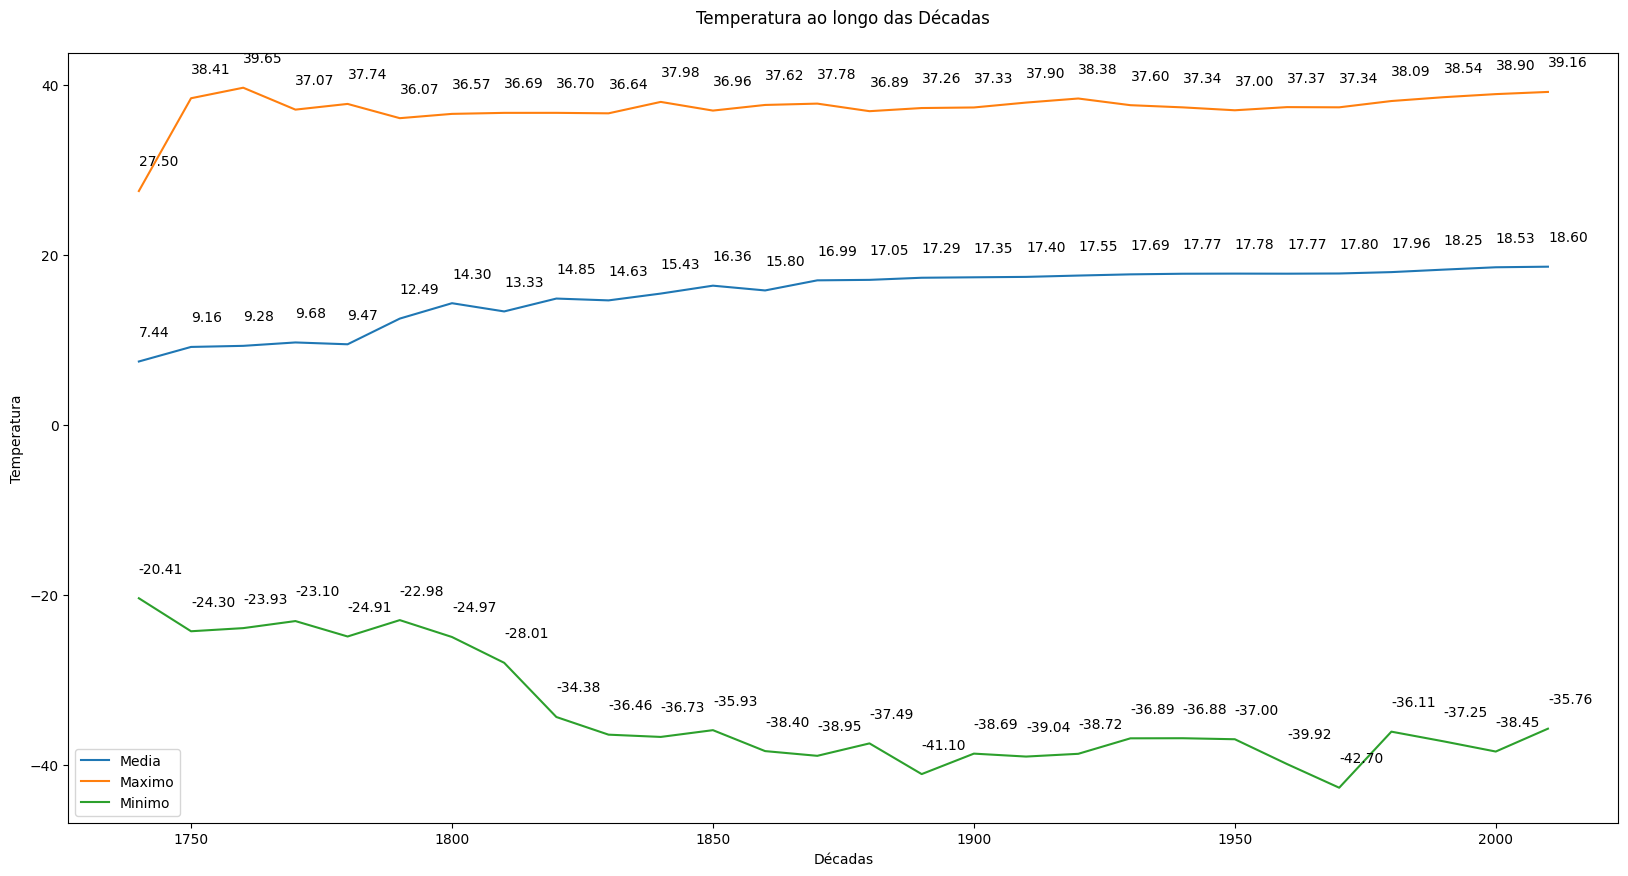

In [29]:
# lineplot:
fig, ax = plt.subplots(figsize=(20, 10)) # Ajuste Tamanho
sns.lineplot(x=decada[decada.columns[0]], y=decada[decada.columns[1]], label='Media')
sns.lineplot(x=decada[decada.columns[0]], y=decada[decada.columns[2]], label='Maximo')
sns.lineplot(x=decada[decada.columns[0]], y=decada[decada.columns[3]], label='Minimo')
plt.title('Temperatura ao longo das Décadas\n')
plt.ylabel('Temperatura')
plt.xlabel('Décadas')

for i in range(0, decada.shape[0]):

    plt.annotate(xy=(decada[decada.columns[0]].iloc[i], 
                         decada[decada.columns[1]].iloc[i]+3),
                             text=f'{decada[decada.columns[1]].iloc[i]:.2f}')

    plt.annotate(xy=(decada[decada.columns[0]].iloc[i], 
                         decada[decada.columns[2]].iloc[i]+3),
                             text=f'{decada[decada.columns[2]].iloc[i]:.2f}')
    
    plt.annotate(xy=(decada[decada.columns[0]].iloc[i], 
                     decada[decada.columns[3]].iloc[i]+3),
                         text=f'{decada[decada.columns[3]].iloc[i]:.2f}')

plt.show()

### Densidade

<p>Distribuição da temperatura média</p>
<p style="text-align: justify">
Podemos verificar que temos a média menor do que a mediana, e a mediana é menor do que a moda (Mo > Md > x̅), o que indica que a distribuição dos dados é assimétrica e com cauda à esquerda.
</p>

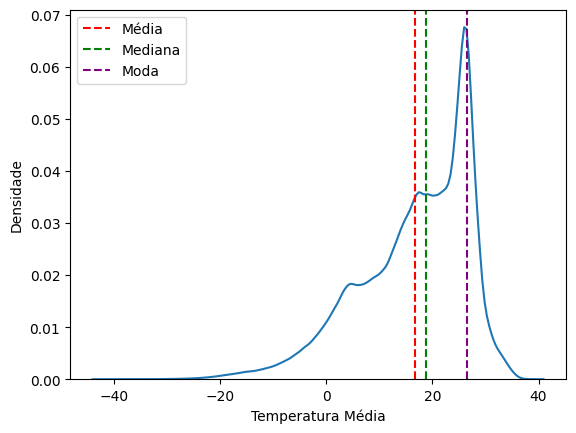

In [6]:
# kdeplot:
sns.kdeplot(x=df['AverageTemperature'])
plt.axvline(np.mean(df['AverageTemperature']), color='red', linestyle='--', label='Média')
plt.axvline(np.median(df['AverageTemperature']), color='green', linestyle='--', label='Mediana')
plt.axvline(mode(df['AverageTemperature'].to_list()), color='purple', linestyle='--', label='Moda')
plt.xlabel('Temperatura Média')
plt.ylabel('Densidade')
plt.legend()
plt.show()


### Temperatura Média dos Continentes por Década

<p style="text-align: justify">
O gráfico em questão mostra a variação da temperatura média global entre os anos 1740 e 2010, dividido por continente. A partir da análise dos dados apresentados, podemos observar que o continente asiático, africano e norte-americano tiveram os maiores aumentos de temperatura entre os anos 1700 e 1850. Isso indica que essas regiões sofreram mais impacto inicialmente do que as outras regiões apresentadas no gráfico. 
    
Após esse período de maior variação, os continentes asiático, africano e norte-americano parecem ter estabilizado suas temperaturas nesses pontos mais altos, enquanto os outros continentes apresentaram temperaturas mais estáveis e menores variações.
</p>

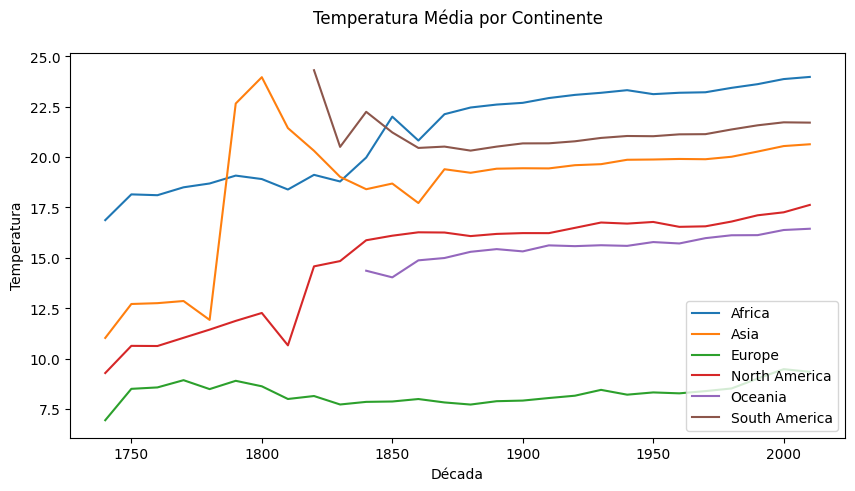

In [7]:
fig, ax = plt.subplots(figsize=(10, 5)) # Ajuste Tamanho

# lineplot:
sns.lineplot(x=continente['decada'], y=continente['AverageTemperature'], hue=continente['Continents'])
plt.xlabel('Década')
plt.ylabel('Temperatura')
plt.title('Temperatura Média por Continente\n')
plt.legend(title='', loc='lower right')
plt.show()


### Boxplot - Continentes

<p style="text-align: justify">Nesse contexto, a análise realizada revelou que a distribuição dos dados de temperatura por continente apresenta diferenças importantes entre os continentes. A África por exemplo apresenta uma temperatura mediana mais alta em comparação com outros continentes, os dados também mostram que a África tem valores extremamente altos (outliers) no Q3.
<br><br>
Por outro lado, a Europa apresenta uma temperatura mediana mais baixa em comparação com outros continentes, mas os dados também mostram que a Europa tem valores extremamente baixos (outliers) no Q1.
</p>

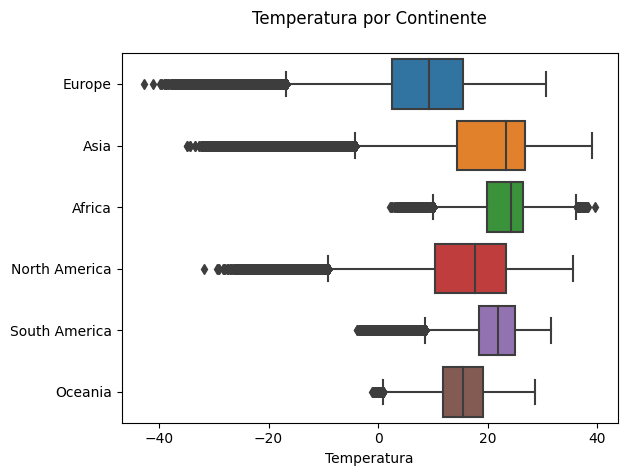

In [8]:
sns.boxplot(x=df['AverageTemperature'], y=df['Continents'], orient='h') # boxplot na horizontal

plt.xlabel('Temperatura')
plt.ylabel('')
plt.title('Temperatura por Continente\n')
plt.show()

### Sazonalidade - Temperatura meses do ano por Continente
<p style="text-align: justify"> Ao observar esses gráficos, é possível detectar padrões claros nas mudanças de temperatura em cada estação do ano. Um exemplo desses padrões pode ser observado nos continentes da Europa, América do Norte e Ásia. Esses continentes apresentam um aumento de temperatura no meio do ano e uma diminuição no começo e no final do ano.

Por outro lado, a Oceania e a América do Sul apresentam um movimento oposto, com uma diminuição de temperatura no meio do ano e um aumento no começo e no final do ano.

Por fim, a África tem uma temperatura que varia muito pouco ao longo do ano. Isso pode ser explicado pelo fato de que a maioria da África está localizada na linha do equador, onde as estações do ano não são tão distintas quanto em outras partes do mundo.</p>

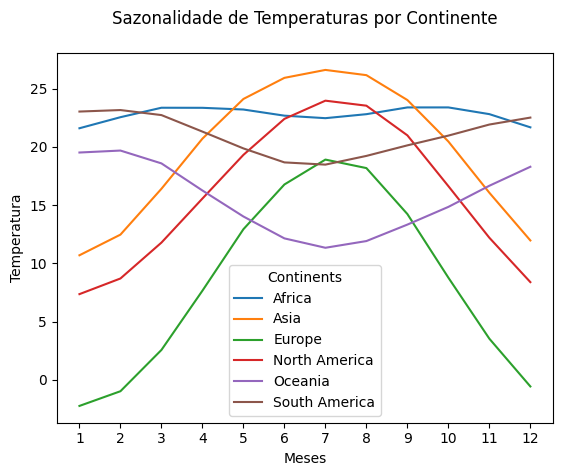

In [9]:
sns.lineplot(x=sazonal['month'], y=sazonal['AverageTemperature'], hue=sazonal['Continents'])
plt.xlabel('Meses')
plt.ylabel('Temperatura')
plt.title('Sazonalidade de Temperaturas por Continente\n')
plt.xticks(sazonal['month'].unique())
plt.show()

### Analise de Outliers

#### Disperção de valores por década

<p style="text-align: justify">
Ao analisar um conjunto de dados de temperatura ao longo do tempo, é possível observar que, embora a mediana da temperatura tenha aumentado, o número de outliers também tem crescido significativamente. Isso sugere que a temperatura não está aumentando de forma consistente, mas sim que há um número crescente de eventos extremos que estão afetando a média. Esses eventos podem incluir ondas de calor, tempestades ou outros fenômenos climáticos extremos.
</p>

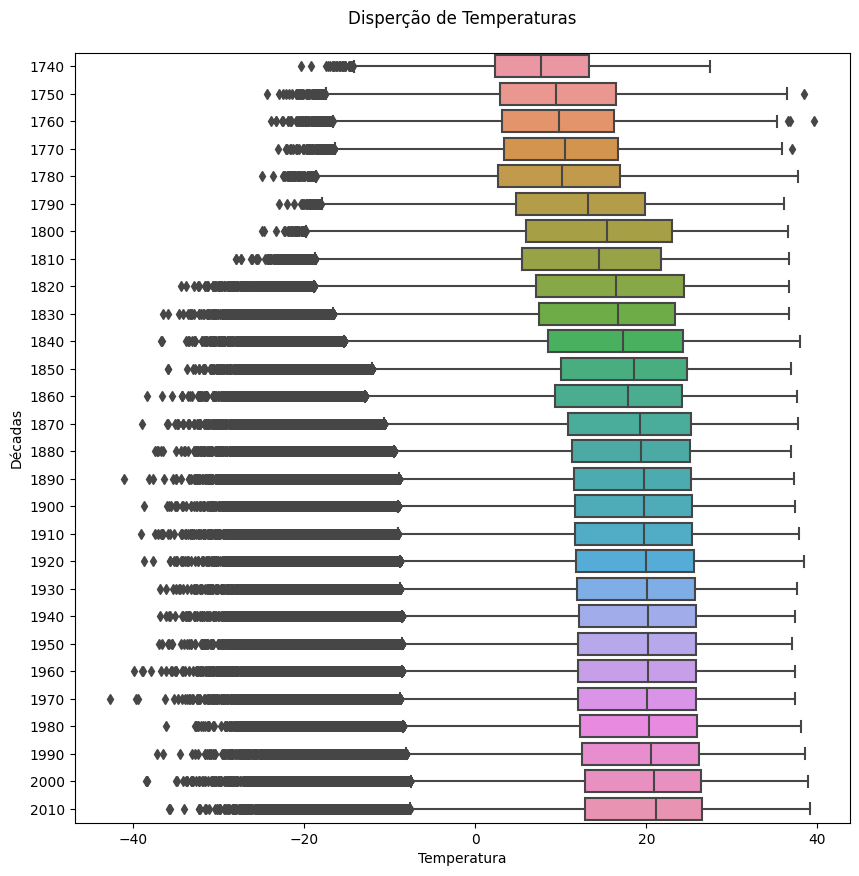

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.boxplot(x=df['AverageTemperature'], y=df['decada'], orient='h') # boxplot na horizontal

plt.title('Disperção de Temperaturas\n')
plt.xlabel('Temperatura')
plt.ylabel('Décadas')
plt.show()

#### Paises com mais participações em outliers baixos (Q1)

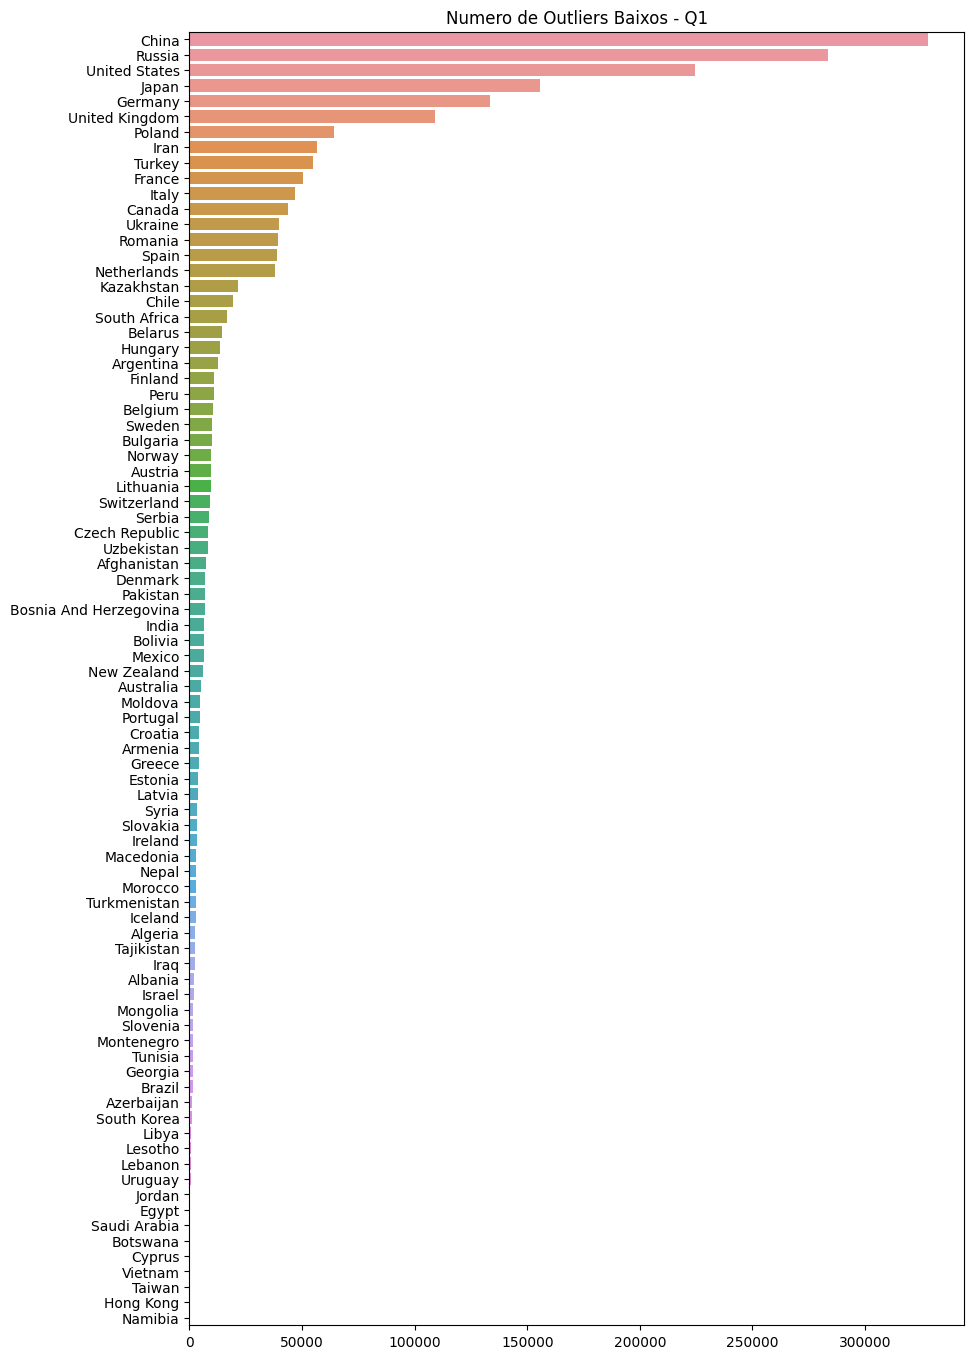

In [11]:
q1 = df.loc[df['outliers'] == 'outlier baixo']
q1['count'] = 1
q1 = q1.groupby('Country', as_index=False)['count'].sum()
q1.sort_values(by='count', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10, q1.shape[0]/5))
sns.barplot(x=q1['count'], y=q1['Country'], orient='h')
plt.title('Numero de Outliers Baixos - Q1')
plt.ylabel('')
plt.xlabel('')
plt.show()

#### Paises com mais participações em outliers alto (Q3)

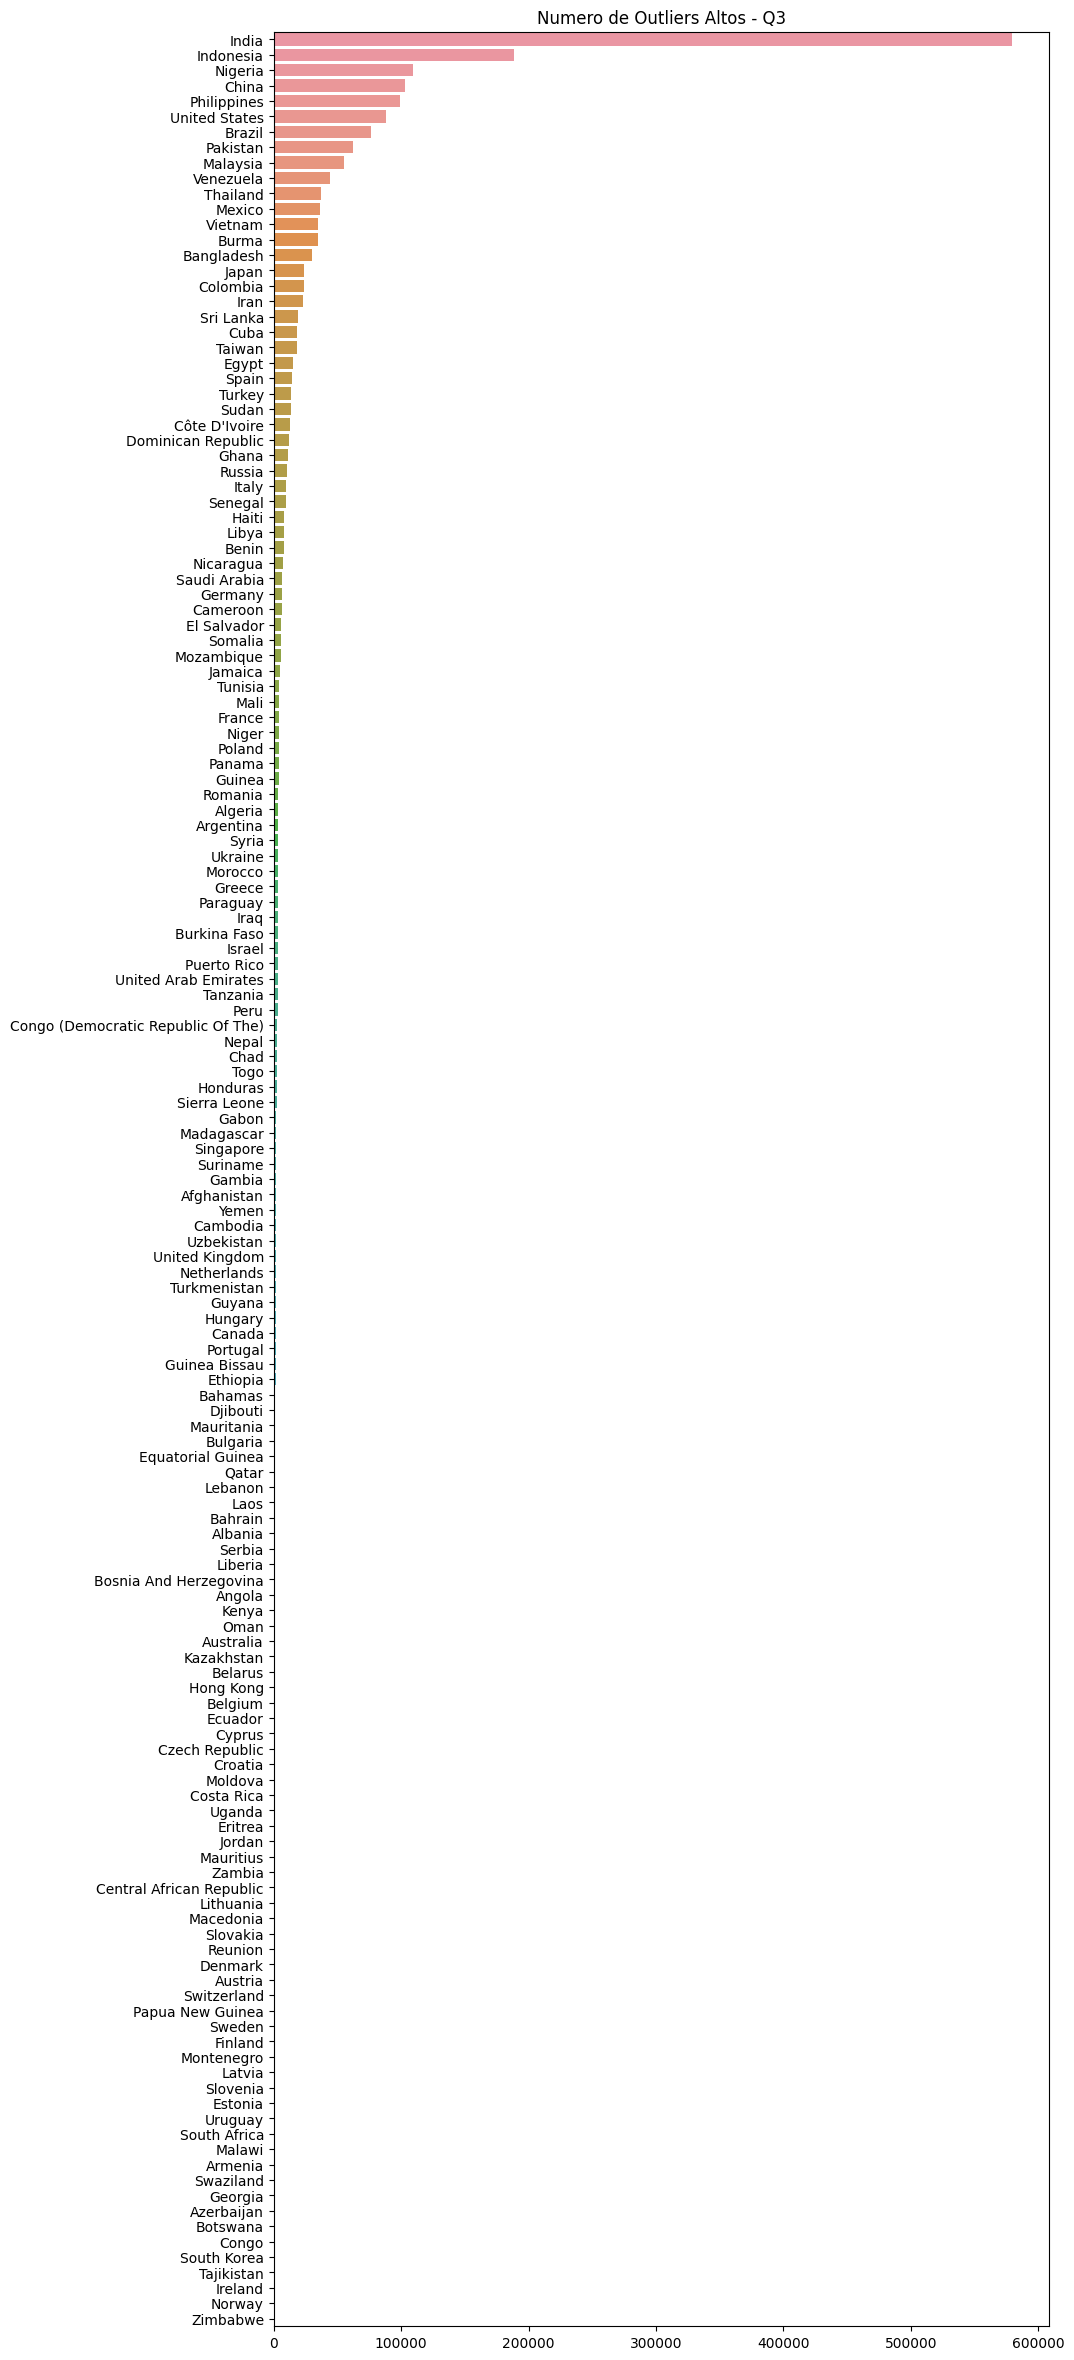

In [12]:
q3 = df.loc[df['outliers'] == 'outlier alto']
q3['count'] = 1
q3 = q3.groupby('Country', as_index=False)['count'].sum()
q3.sort_values(by='count', ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(10, q3.shape[0]/5))
sns.barplot(x=q3['count'], y=q3['Country'], orient='h')
plt.title('Numero de Outliers Altos - Q3')
plt.xlabel('')
plt.ylabel('')
plt.show()